# Stock Recommendation Based on Sentiment Analysis

www.finviz.com


In [171]:
# library
from bs4 import BeautifulSoup
import os
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [172]:
# The .html files are saved in the 'datasets' folder. 
# In each html file, the infomration that we want is in the section 
# where the id = 'news-table'
html_tbls = dict()
for file in os.listdir('datasets'): 
    filepath = f'datasets/{file}'
#     html = BeautifulSoup(open(filepath),features="xml")
    html = BeautifulSoup(open(f'datasets/{file}','r'))
    html_tbl=html.find(id='news-table') 
    html_tbls[file]=html_tbl

In [173]:
files = os.listdir('datasets')
print('There are these files in the datasets folder: ', files, '\n')
tsla = html_tbls['tsla_22sep.html'] #randomly pick one of them to peak
tsla_tr = gpro.findAll('tr')
for i, table_row in enumerate(gpro_tr): 
    if i<3: #just peak the first 3 
        link_a = table_row.a.get_text() #Read the text contents of the <a> tag
        link_td = table_row.td.get_text()#Read the contents of the <td> tag.
        print('Sample link_a', i, link_a)
        print('Sample link_td', i, link_td)

There are these files in the datasets folder:  ['ba_03jun.html', 'fb_05ene.html', 'fb_22sep.html', 'gpro_06jun.html', 'nvda_06jun.html', 'tsla_05ene.html', 'tsla_22sep.html', 'tsla_26nov.html'] 

Sample link_a 0 Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sample link_td 0 Sep-21-18 09:56PM  
Sample link_a 1 Broadcoms Stock Looks Like a Winner
Sample link_td 1 09:30PM  
Sample link_a 2 SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
Sample link_td 2 05:30PM  


#### Observation
As seen above, the information inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags. 

link_td* to store the <code>&lt;td&gt;</code> which has the date/time; 

link_a* to store the <code>&lt;a&gt;</code> which has the content. 

Next Action: parse the data for <strong>all</strong> tables in a comfortable data structure.


In [174]:
parsed_news = []
for file, news_table in html_tbls.items(): 
    for x in news_table.findAll('tr'): 
        headline = x.a.get_text()
        date_scrape = x.td.get_text().split() 
        if len(date_scrape) ==1: 
            date = date_scrape[0]
        else: 
            date = date_scrape[0]
            time = date_scrape[1]
        symbol = file.split('_')[0]
        parsed_news.append([symbol, date, time, headline])

print('Peak of the last item:')
print(parsed_news[-1])

Peak of the last item:
['tsla', '05:00AM', '06:50PM', 'Meet the man who runs Teslas Gigafactory 2 in Buffalo']


#### Add financial keywords to the nltk analysis

In [175]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,'crushed': 10,
    'beats': 5,'beat': 5,
    'misses': -5,'missed': -5,
    'trouble': -10,'troubled'
    'falls': -100,'fell': -100    
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [176]:
base_df = pd.DataFrame(data=parsed_news, 
                       columns = ['sym', 'date', 'time', 'headline'])
scores = [vader.polarity_scores(i) for i in base_df['headline'].values]
scores_df = pd.DataFrame(scores)
base_df = pd.concat([base_df, scores_df], axis=1)
base_df['date'] = pd.to_datetime(base_df['date']).dt.date
base_df['time'] = pd.to_datetime(base_df['time']).dt.time
# print(base_df['headline'].count())

# Remove Duplicates Headlines
base_df = base_df.drop_duplicates(subset = ['sym', 'headline'])

print('The Base Table Below: ')
display(base_df.head(2))
# print(base_df['headline'].count())

The Base Table Below: 


,sym,date,time,headline,compound,neg,neu,pos
0,ba,2020-06-03,16:38:00,Stock Market Today: Dow Shoots Past 26K in Thi...,0.6486,0.000,0.629,0.371
1,ba,2020-06-04,16:38:00,Stock market news live updates: Stocks rise fo...,-0.5106,0.225,0.693,0.082


## See a Single Stock's Single Day Score over Time of Day

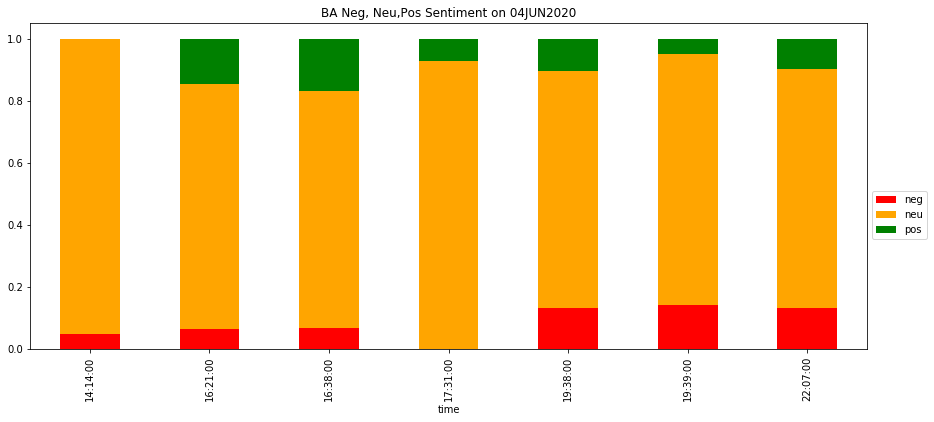

In [177]:
# Only want to see BA on Jun 4, 2020
mydate = datetime.date(year=2020,month=6,day=4)
mystock = 'ba'
sym_date_time = base_df.groupby(['sym', 'date', 'time'], as_index = False).mean()

mystock_mydate = sym_date_time[sym_date_df['sym']==mystock]
mystock_mydate = mystock_mydate[mystock_mydate['date'] == mydate]
mystock_mydate = mystock_mydate.drop(columns = ['compound'])
mystock_mydate.set_index('time')

mystock_mydate.plot.bar(x='time', stacked = True, figsize=(15,6),
                title = "BA Neg, Neu,Pos Sentiment on 04JUN2020", 
                color=['red','orange','green']).legend(bbox_to_anchor=(1,0.5))
                                               

## See Various Stocks' Recent Compound Ratings Over Time

I am really interested in seeing recent Compound scores of all these stocks in my profile over the past 3 weeks. 

In [178]:
sym_date = base_df.groupby(['sym', 'date'], as_index = False).mean()
startdate = datetime.date.today()- datetime.timedelta(days=21)

sym_date = sym_date[sym_date['date']>=startdate]
sym_date = sym_date.drop(columns = ['neg', 'neu', 'pos'])
sym_date.set_index('date')
display(sym_date.head(10))

,sym,date,compound
0,ba,2020-05-28,0.000000
1,ba,2020-05-29,0.000000
2,ba,2020-05-30,0.493900
3,ba,2020-05-31,0.025800
4,ba,2020-06-01,-0.510600
5,ba,2020-06-02,0.000000
6,ba,2020-06-03,0.648600
7,ba,2020-06-04,0.009741
21,fb,2020-06-04,0.032805
74,gpro,2020-05-20,0.000000


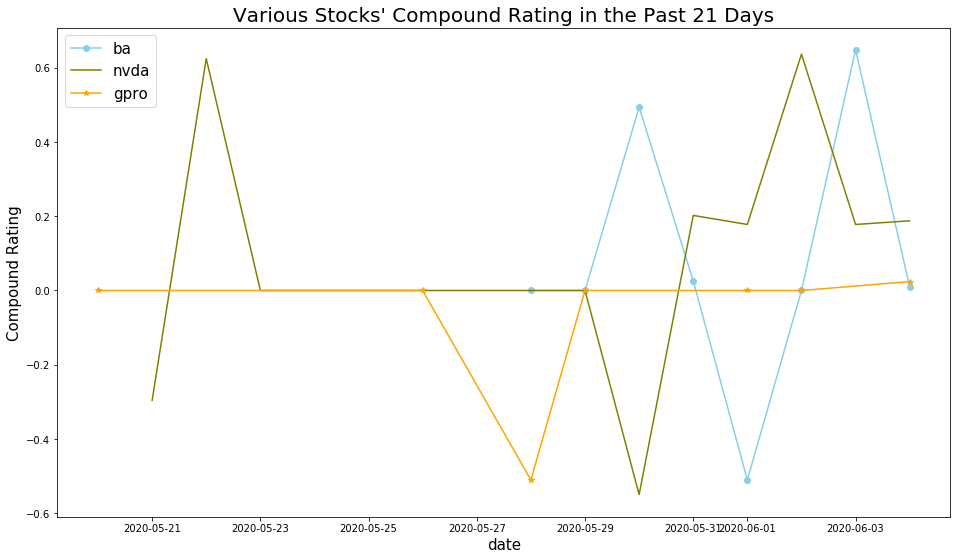

In [179]:
plt.figure(figsize=(16, 9))
plt.plot( 'date', 'compound', data=sym_date[sym_date['sym']=='ba'], marker='o', 
         color='skyblue', label='ba')
plt.plot( 'date', 'compound', data=sym_date[sym_date['sym']=='nvda'], marker='', 
         color='olive', label='nvda')
plt.plot( 'date', 'compound', data=sym_date[sym_date['sym']=='gpro'], marker='*', 
         color='orange', label="gpro") #linewidth=2, linestyle='dashed'
plt.title("Various Stocks' Compound Rating in the Past 21 Days",
         fontsize=20)
plt.xlabel('date', fontsize=15)
plt.ylabel('Compound Rating', fontsize=15)
plt.legend(fontsize=15)
plt.show()
                                            
